<a href="https://colab.research.google.com/github/mgswiss15/deepul/blob/2023/20221216_Homework_1_Autoregressive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone https://github.com/mgswiss15/deepul.git
    !git checkout 2023
    !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
    !pip install ./deepul
# else:
#     !pwd
#     !pip install ../../../deepul

In [7]:
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


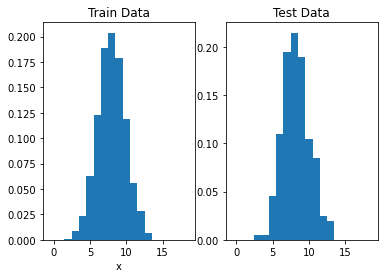

Dataset 2


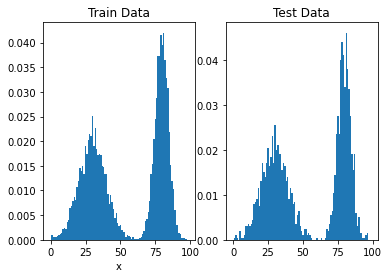

In [5]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

### MG comments

$p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

This means that

$\log p_\theta(x) = \theta_x - \log \sum_{x'}e^{\theta_{x'}}$ (careful about logsumexp)

and

$\text{nll} = -\frac{1}{n} \sum_i^n \log p_\theta(x_i) = -\frac{1}{n} \sum_i^n \theta_{x_i} + \log \sum_{x'}e^{\theta_{x'}}$, 

where the second term is a constant independent of $x_i$.

The gradient of nll with respect to $\theta$ parameters is then

$\nabla{\theta_x} \text{nll} = -\frac{1}{n} \sum_i^n I[x_i = x] + \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

since the grad of logsumexp is a softmax.

We can actually pre-calculate the first term of the gradient as it actually does not depend on $\theta$ - `grad_part1` in the code.

The second term needs to be updated during the sgd - `grad_part2`.




In [8]:
# helper funciton for batching
def get_bindex(n, b_size):
  idx = np.random.permutation(n)
  for i in range(0, n, b_size):
    b_index = idx[i:i+b_size]
    yield b_index

In [7]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  """ YOUR CODE HERE  - NO BATCHING """
  import scipy.special as ssp
  # init parameters
  theta = np.zeros(d)
  n = len(train_data)
  b_size = 64

  def get_nll(data, params):
    # parameters corresponding to data
    p_data = params[data]
    # negative log likelihood
    return -np.mean(p_data) + ssp.logsumexp(params)

  # train model by sgd
  lr = 1
  n_epochs = 1000
  nll_train = []
  nll_test = [get_nll(test_data, theta)]
  for epoch in range(n_epochs):
    # batches
    gen_batches = get_bindex(n, b_size)
    for b_idx in gen_batches:
      batch = train_data[b_idx]
      # part1 of gradient
      unique_vals, unique_counts = np.unique(batch, return_index=False, return_inverse=False, return_counts=True)
      grad_part1 = np.zeros(d)
      grad_part1[unique_vals] = - unique_counts / len(batch)
      # part2 of gradient
      grad_part2 = ssp.softmax(theta)
      grads = grad_part1 + grad_part2
      # sgd step
      theta -= lr * grads
      # monitor train nll
      nll_train.append(get_nll(batch, theta))
    # monitor test nll
    nll_test.append(get_nll(test_data, theta))

  return np.array(nll_train), np.array(nll_test), ssp.softmax(theta)


  # """ YOUR CODE HERE  - NO BATCHING """
  # import scipy.special as ssp
  # # init parameters
  # theta = np.zeros(d)
  # n = len(train_data)

  # # get part1 of gradient
  # unique_vals, unique_counts = np.unique(train_data, return_index=False, return_inverse=False, return_counts=True)
  # grad_part1 = np.zeros(d)
  # grad_part1[unique_vals] = - unique_counts / n

  # # train model by sgd
  # lr = 1
  # n_epochs = 1000
  # nll_train = []
  # nll_test = []
  # for epoch in range(n_epochs):
  #   # thetas corresponding to train data
  #   thetas = theta[train_data]
  #   nll = -np.mean(thetas) + ssp.logsumexp(theta)
  #   nll_train.append(nll)
  #   # second part of gradient
  #   grad_part2 = ssp.softmax(theta)
  #   grads = grad_part1 + grad_part2
  #   # sgd step
  #   theta -= lr * grads
  #   # thetas corresponding to test data
  #   thetas = theta[test_data]
  #   nll = -np.mean(thetas) + ssp.logsumexp(theta)
  #   nll_test.append(nll)

  # return np.array(nll_train), np.array(nll_test), ssp.softmax(theta)
  

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.0516


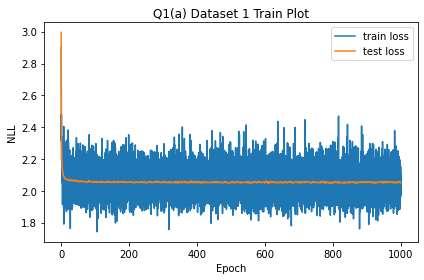

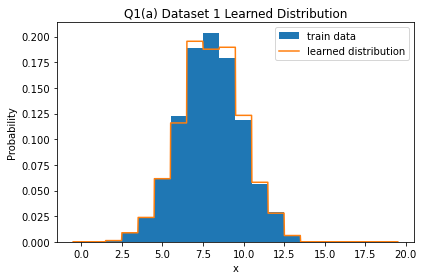

In [8]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 4.0345


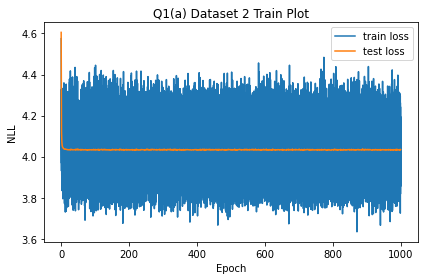

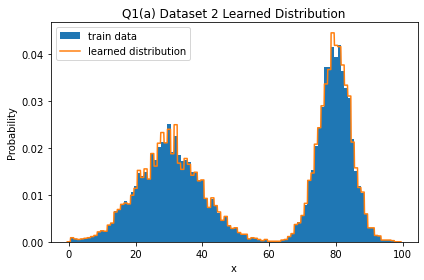

In [9]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

### MG comments

$p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

which means

$\log p_\theta(x) = \log \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

and 

$nll = - \sum_j^n \log p_\theta(x_j) = - \sum_j^n \log \sum_{i=1}^4 \pi_i[\sigma((x_j+0.5 - \mu_i)/s_i) - \sigma((x_j-0.5-\mu_i)/s_i)]$

or I can also do 

$nll = - \sum_j^n \log \sum_{i=1}^4 \exp \left(\log \pi_i + \log [\sigma((x_j+0.5 - \mu_i)/s_i) - \sigma((x_j-0.5-\mu_i)/s_i)]\right)$


In [10]:
a = torch.arange(4)
b = torch.ones(4)
a[torch.where(a == b)] = 100.
a

tensor([  0, 100,   2,   3])

In [11]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    """ YOUR CODE HERE """
    import scipy.special as ssp
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F

    # move from numpy to torch
    train_data = torch.from_numpy(train_data[:,None])
    test_data = torch.from_numpy(test_data[:,None])

    #normalize data
    # train_data = (train_data) / 20
    # test_data = test_data/20

    # init parameters
    upi = torch.nn.Parameter(torch.ones(1,4)) # unnormalized probs of mixtures
    mu = torch.nn.Parameter(torch.arange(4.)[None,:] *d/4.)
    logs = torch.nn.Parameter(torch.ones(1,4)*3.) # logs of std

    # init constants
    n = len(train_data)
    b_size = 512

#   def get_logprobs(data, params):
#     upis, mus, logss = params
#     # normalize mixture probabilities
#     # pis = F.softmax(upis, dim=1)
#     # get stds
#     ss = logss.exp()
#     # probs as mixture of logistics
#     center_x = data - mus
#     # cdf of logistcs
#     cdf_left = torch.sigmoid((center_x - 0.5 ) / ss)
#     cdf_right = torch.sigmoid((center_x + 0.5 ) / ss)
#     # extreme values
#     cdf_left = torch.where(center_x == -mus, torch.zeros(1), cdf_left)
#     cdf_right = torch.where(center_x == d-1-mus, torch.ones(1), cdf_right)
#     # pmfs
#     pmfs = torch.clamp(cdf_right - cdf_left,1e-15)
#     log_pmfs = pmfs.log()
#     log_pis = F.log_softmax(upis, dim=1)
#     return torch.logsumexp(log_pis + log_pmfs, dim=1)


#   def get_nll(data, params):
#     # get log_probs
#     log_probs = get_logprobs(data, params)
#     # negative log likelihood
#     return -torch.mean(log_probs)

#   # train model by sgd
#   lr = 0.1
#   n_epochs = 100
#   optimizer = optim.SGD([upi, mu, logs], lr=lr)

#   nll_train = []
#   nll_test = [get_nll(test_data, [upi.detach(), mu.detach(), logs.detach()]).item()]
#   for epoch in range(n_epochs):
#     # batches
#     gen_batches = get_bindex(n, b_size)
#     for b_idx in gen_batches:
#       optimizer.zero_grad(set_to_none=True)
#       batch = train_data[b_idx]
#       # get loss
#       nll = get_nll(batch, [upi, mu, logs])
#       # sgd step
#       nll.backward()
#       optimizer.step()
#       # monitor train nll
#       nll_train.append(nll.item())
#     # monitor test nll
#     nll_test.append(get_nll(test_data, [upi.detach(), mu.detach(), logs.detach()]).item())

#   log_probs = get_logprobs(torch.arange(d)[:,None], [upi, mu, logs])
#   print(f'probs: {log_probs.exp().sum(), log_probs.exp().shape}')
    
#   return np.array(nll_train), np.array(nll_test), log_probs.exp().detach().numpy()

    def get_probs(data, params):
        upis, mus, logss = params
        # normalize mixture probabilities
        pis = F.softmax(upis, dim=1)
        # get stds
        ss = logss.exp()
        # probs as mixture of logistics
        center_x = data - mus
        # cdf of logistcs
        cdf_left = torch.sigmoid((center_x - 0.5 ) / ss)
        cdf_right = torch.sigmoid((center_x + 0.5 ) / ss)
        # extreme values
        cdf_left = torch.where(center_x == -mus, torch.zeros(1), cdf_left)
        cdf_right = torch.where(center_x == d-1-mus, torch.ones(1), cdf_right)
        # pmfs
        pmfs = torch.clamp(cdf_right - cdf_left,1e-15)
        return (pis*pmfs).sum(dim=1)
        # log_pmfs = pmfs.log()
        # log_pis = F.log_softmax(upis, dim=1)
        # return torch.logsumexp(log_pis + log_pmfs, dim=1)


    def get_nll(data, params):
        # get probs
        probs = get_probs(data, params)
        # negative log likelihood
        return -torch.mean(torch.log(probs))

    # train model by sgd
    lr = 0.1
    n_epochs = 100
    optimizer = optim.SGD([upi, mu, logs], lr=lr)

    nll_train = []
    nll_test = [get_nll(test_data, [upi.detach(), mu.detach(), logs.detach()]).item()]
    for epoch in range(n_epochs):
        # batches
        gen_batches = get_bindex(n, b_size)
        for i, b_idx in enumerate(gen_batches):
            optimizer.zero_grad(set_to_none=True)
            batch = train_data[b_idx]
            # get loss
            nll = get_nll(batch, [upi, mu, logs])
            # sgd step
            nll.backward()
            optimizer.step()
            # monitor train nll
            nll_train.append(nll.item())
        # monitor test nll
        nll_test.append(get_nll(test_data, [upi.detach(), mu.detach(), logs.detach()]).item())

    probs = get_probs(torch.arange(d)[:,None], [upi, mu, logs])
    print(f'probs: {probs.sum(), probs.shape}')

    return np.array(nll_train), np.array(nll_test), probs.detach().numpy()

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



probs: (tensor(1., grad_fn=<SumBackward0>), torch.Size([20]))
Final Test Loss: 2.1454


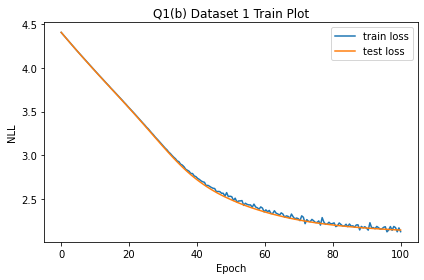

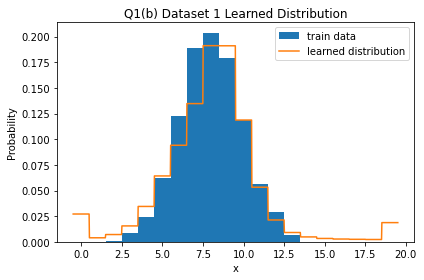

CPU times: user 852 ms, sys: 12.1 ms, total: 864 ms
Wall time: 290 ms


In [12]:
%%time
q1_save_results(1, 'b', q1_b)

probs: (tensor(1., grad_fn=<SumBackward0>), torch.Size([100]))
Final Test Loss: 4.0590


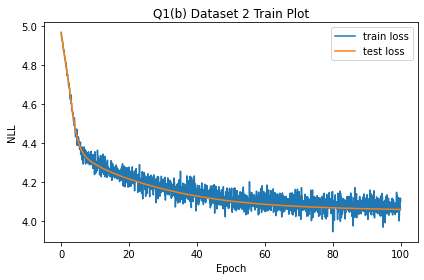

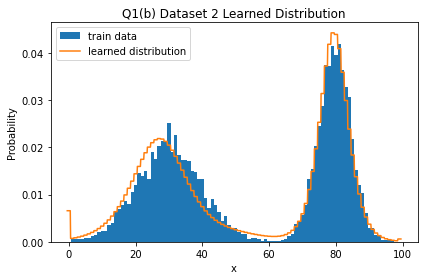

CPU times: user 1.44 s, sys: 8.11 ms, total: 1.45 s
Wall time: 890 ms


In [13]:
%%time
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

true_dist (25, 25)
data (10000, 2)
Dataset 1


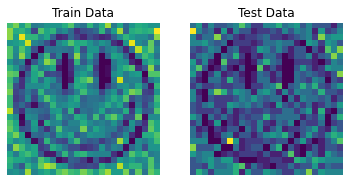

Dataset 2


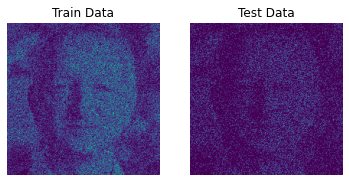

In [14]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [9]:
import hw1

In [16]:
a = torch.zeros(2,2,5).int()
a[0,0,2]=1
a[0,1,3]=1
a[1,0,0]=1
a[1,1,2]=1
a

tensor([[[0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0]],

        [[1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0]]], dtype=torch.int32)

In [19]:
a[:,0,:].unsqueeze(2).shape
a[:,1,:].unsqueeze(1).shape
torch.bmm(a[:,0,:].unsqueeze(2), a[:,1,:].unsqueeze(1))

tensor([[[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]], dtype=torch.int32)

### MG comments

First trying a solution where the input data is left in the original 2D shape.

In [18]:
def q2_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """

    # THIS uses the original 2D data
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    import itertools
    

    # move from numpy to torch
    train_data = torch.from_numpy(train_data).float()
    test_data = torch.from_numpy(test_data).float()
    n_train = train_data.shape[0]
      
    made = hw1.MADE(64, d)
    
    # train model by sgd
    lr = 0.1
    n_epochs = 5000
    optimizer = optim.SGD(made.parameters(), lr=lr)
    b_size = 1024
    
    
    def get_nll(input, target):
        input = input.view(-1,2,d).transpose(1,2)
        return F.cross_entropy(input, target.long())

    nll_train = []
    with torch.no_grad():
        nll_test = [get_nll(made(test_data), test_data).item()]
    for epoch in range(n_epochs):
        # batches
        gen_batches = get_bindex(n_train, b_size)
        for b_idx in gen_batches:
            optimizer.zero_grad(set_to_none=True)
            batch = train_data[b_idx]
            logits = made(batch)
            # get loss
            nll = get_nll(logits, batch)
            # sgd step
            nll.backward()
            optimizer.step()
            # monitor train nll
            nll_train.append(nll.item())
        # monitor test nll
        with torch.no_grad():
            nll_test.append(get_nll(made(test_data), test_data).item())
        if epoch % 100 == 0:
            print(f'Epoch {epoch}')
  
    with torch.no_grad():
        pairs = list(itertools.product(range(d), range(d)))
        all_data = torch.tensor(pairs).float()
        logits = made(all_data).view(-1,2,d)
        probs = logits.softmax(2)
        pps = torch.zeros(d, d)
        for i in range(len(pairs)):
            pps[pairs[i]] = probs[i][0][pairs[i][0]]*probs[i][1][pairs[i][1]]
        pps = pps / pps.sum()
            
    
    return np.array(nll_train[10:]), np.array(nll_test[1:]), pps.detach().numpy()    

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900
Final Test Loss: 3.1942


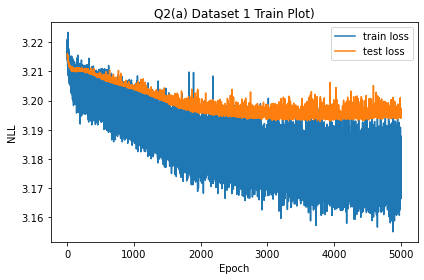

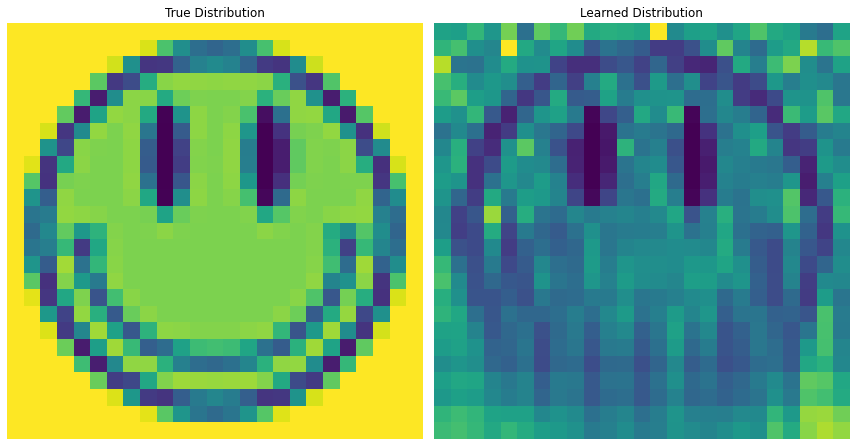

In [19]:
q2_save_results(1, 'a', q2_a)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900
Final Test Loss: 5.2718


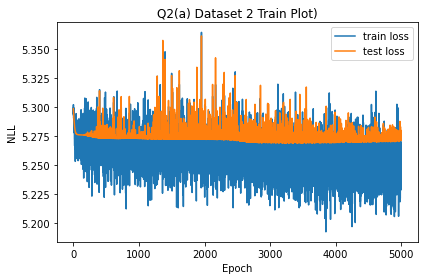

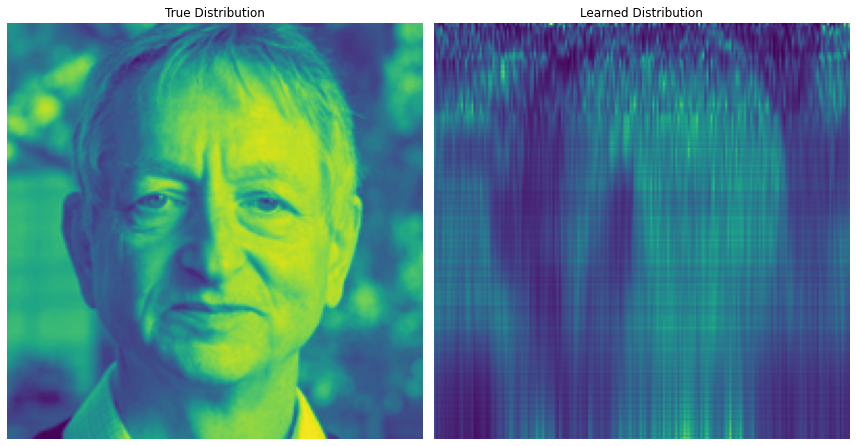

In [75]:
q2_save_results(2, 'a', q2_a)

In [39]:
def q2_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """

    # THIS uses the onehot encoding or the original 2D data
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    import itertools
    

    # move from numpy to torch
    train_data = torch.from_numpy(train_data)
    test_data = torch.from_numpy(test_data)
    n_train = train_data.shape[0]
    
    # one hot encoding of data
    train_oh = F.one_hot(train_data).view(-1, 2*d).float()
    test_oh = F.one_hot(test_data).view(-1, 2*d).float()
      
    made = hw1.MADE_oh(128, d)
    
    # train model by sgd
    lr = 0.1
    n_epochs = 1000
    optimizer = optim.SGD(made.parameters(), lr=lr)
    b_size = 1024
    
    
    def get_nll(input, target):
        input = input.view(-1,2,d).transpose(1,2)
        target = target.view(-1,2,d).transpose(1,2)
        return F.cross_entropy(input, target)

    nll_train = []
    with torch.no_grad():
        nll_test = [get_nll(made(test_oh), test_oh).item()]
    for epoch in range(n_epochs):
        # batches
        gen_batches = get_bindex(n_train, b_size)
        for b_idx in gen_batches:
            optimizer.zero_grad(set_to_none=True)
            batch = train_oh[b_idx]
            logits = made(batch)
            # get loss
            nll = get_nll(logits, batch)
            # sgd step
            nll.backward()
            optimizer.step()
            # monitor train nll
            nll_train.append(nll.item())
        # monitor test nll
        with torch.no_grad():
            nll_test.append(get_nll(made(test_oh), test_oh).item())
        if epoch % 100 == 0:
            print(f'Epoch {epoch}')
  
    with torch.no_grad():
        pairs = list(itertools.product(range(d), range(d)))
        all_data = torch.tensor(pairs)
        all_oh = F.one_hot(all_data).view(-1, 2*d).float()
        logits = made(all_oh).view(-1,2,d)
        probs = logits.softmax(2)
        pps = torch.zeros(d, d)
        for i in range(len(pairs)):
            pps[pairs[i]] = probs[i][0][pairs[i][0]]*probs[i][1][pairs[i][1]]
        pps = pps / pps.sum()
            
    
    return np.array(nll_train[10:]), np.array(nll_test[1:]), pps.detach().numpy()    

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Final Test Loss: 3.1931


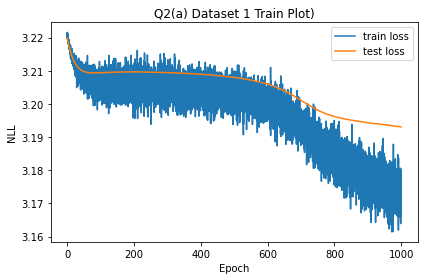

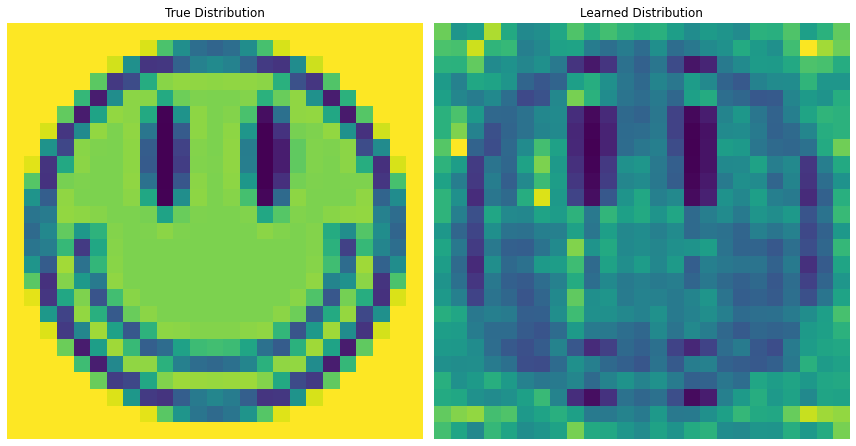

In [40]:
q2_save_results(1, 'a', q2_a)

In [ ]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(1, 'b', q2_b)

In [ ]:
q2_save_results(2, 'b', q2_b)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



In [ ]:
q3a_save_results(1, q3_a)

In [ ]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

In [ ]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



In [ ]:
q3bc_save_results(1, 'b', q3_b)

In [ ]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



In [ ]:
q3bc_save_results(1, 'c', q3_c)

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



In [ ]:
q3d_save_results(1, q3_d)

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [ ]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [ ]:
q4c_save_results(q4_c)